In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pymorphy2
!pip install spacy
!python -m spacy download ru_core_news_sm
!pip install bertopic

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 87.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=b19ce2ce0fc6f7dcbb564a5eddd88d50755179ba199334f142d936ec76f6ee8a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 87.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by sele

In [3]:
import spacy
import re
import pymorphy2
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import spacy

import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, manhattan_distances
from bertopic import BERTopic
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = '/content/drive/MyDrive/Colab Notebooks/Crime And Punishment.txt'

with open(data, 'r', encoding='utf-8') as file:
    text = file.read()

print(text[:1000])

Annotation


«Преступление и наказание» – гениальный роман, главные темы которого: преступление и наказание, жертвенность и любовь, свобода и гордость человека – обрамлены почти детективным сюжетом.

Многократно экранизированный и не раз поставленный на сцене, он и по сей день читается на одном дыхании.





* * *



Часть перваяI

II

III

IV

V

VI

VII





Часть втораяI

II

III

IV

V

VI

VII





Часть третьяI

II

III

IV

V

VI





Часть четвертаяI

II

III

IV

V

VI





Часть пятаяI

II

III

IV

V





Часть шестаяI

II

III

IV

V

VI

VII

VIII





ЭпилогI

II





notes1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95





* * *





Часть первая




I



Предобработка

In [5]:
# удаление заголовков и номеров частей
text = re.sub(r'\bЧасть\s+\S+\s*\n', '', text, flags=re.IGNORECASE)
text = re.sub(r'\bЭпилог\b', '', text, flags=re.IGNORECASE)
text = re.sub(r'\bnotes\d+', '', text, flags=re.IGNORECASE)
text = re.sub(r'\bAnnotation\b', '', text, flags=re.IGNORECASE)
text = re.sub(r'\n\s*\n+', '\n\n', text)

# разделение текста на абзацы
paragraphs = text.split('\n\n')

# удаление пустых абзацев
paragraphs = [p for p in paragraphs if p.strip()]

print(f"Всего абзацев: {len(paragraphs)}")
print(paragraphs[:5])

Всего абзацев: 3953
['«Преступление и наказание» – гениальный роман, главные темы которого: преступление и наказание, жертвенность и любовь, свобода и гордость человека – обрамлены почти детективным сюжетом.', 'Многократно экранизированный и не раз поставленный на сцене, он и по сей день читается на одном дыхании.', '* * *', 'II', 'III']


In [26]:
nlp = spacy.load("ru_core_news_sm")
morph = MorphAnalyzer()
nltk.download('punkt')

def clean_text(text):
    text = re.sub(r'\n\s*\n+', '\n\n', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\b[ivxlcdm]+\b', '', text, flags=re.IGNORECASE)  # удаление римских чисел
    text = re.sub(r'\d+', '', text)

    tokens = word_tokenize(text)
    stop_words = nlp.Defaults.stop_words
    tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens]

    return ' '.join(lemmatized_tokens)

text = re.sub(r'\bЧасть\s+\S+\s*\n', '', text, flags=re.IGNORECASE)
text = re.sub(r'\bЭпилог\b', '', text, flags=re.IGNORECASE)
text = re.sub(r'\bэпилогi\b', '', text, flags=re.IGNORECASE)  # удаление "эпилогi"
text = re.sub(r'\bnotes\d+', '', text, flags=re.IGNORECASE)
text = re.sub(r'\bAnnotation\b', '', text, flags=re.IGNORECASE)
text = re.sub(r'\* \* \*', '', text, flags=re.IGNORECASE)
text = re.sub(r'\n\s*\n+', '\n\n', text)

# разделение текста на абзацы
paragraphs = text.split('\n\n')

# удаление пустых абзацев
paragraphs = [p for p in paragraphs if p.strip()]

processed_paragraphs = [clean_text(p) for p in paragraphs]
processed_paragraphs = [p for p in processed_paragraphs if p.strip()]

for i, para in enumerate(processed_paragraphs[:5]):
    print(f'Абзац {i+1}: {para}\n')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Абзац 1: преступление наказание гениальный роман главный тема преступление наказание жертвенность любовь свобода гордость человек обрамить детективный сюжет

Абзац 2: многократно экранизировать раз поставить сцена день читаться дыхание

Абзац 3: июль чрезвычайно жаркое время вечер молодой человек выйти каморка нанимать жилец смотреть переулок улица медленно нерешимость отправиться кну мост

Абзац 4: благополучно избегнуть встреча хозяйка лестница каморка приходиться самый кровля высокий пятиэтажный дом походить шкаф квартира квартирный хозяйка нанимать каморка обед прислуга помещаться лестница отдельный квартира раз выход улица непременно проходить хозяйкин кухня настежь отворить лестница раз молодой человек проходить чувствовать какоеть болезненный трусливый ощущение стыдиться морщиться кругом хозяйка бояться встретиться

Абзац 5: трусливый забитый некоторый время раздражительный напрячь состояние ипохондрия углубиться уединиться бояться встреча встреча хозяйка задавить бедность стесн

Информация о тексте

In [27]:
processed_tokens = clean_text(text)

# количество всех слов
total_words = len(processed_tokens)
print(f'Количество всех слов: {total_words}')

# количество уникальных слов
unique_words = len(set(processed_tokens))
print(f'Количество уникальных слов: {unique_words}')

sentences = sent_tokenize(text)
total_sentences = len(sentences)
print(f'Количество предложений: {total_sentences}')

# средняя длина предложения
average_sentence_length = total_words / total_sentences
print(f'Средняя длина предложения: {average_sentence_length:.2f}')

Количество всех слов: 657669
Количество уникальных слов: 65
Количество предложений: 13300
Средняя длина предложения: 49.45


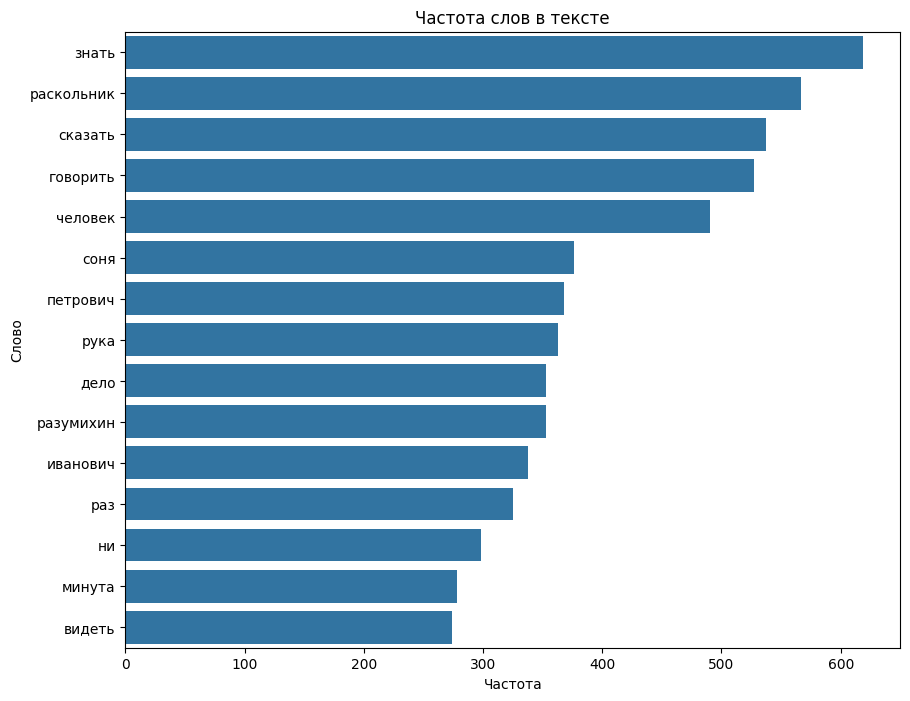

In [28]:
df = pd.DataFrame({'paragraph': processed_paragraphs})

# наиболее частые слова в тексте
def plot_top_words(data, text_column, num_words=15):
    all_words = ' '.join(data[text_column]).split()
    word_freq = Counter(all_words).most_common(num_words)
    words, freqs = zip(*word_freq)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title('Частота слов в тексте')
    plt.xlabel('Частота')
    plt.ylabel('Слово')
    plt.show()

plot_top_words(df, text_column='paragraph', num_words=15)

### SentenceTransformer

In [11]:
from transformers import BertModel, BertTokenizer
import torch

"""# Загрузка модели и токенизатора BERT
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Функция для получения эмбеддингов предложений
def get_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
    return np.array(embeddings)

# Получение эмбеддингов для всех предложений
embeddings = get_embeddings(processed_sentences)"""


from sentence_transformers import SentenceTransformer

model_t = SentenceTransformer('all-mpnet-base-v2')
embeddings =model_t.encode(processed_paragraphs)
print(embeddings.shape)

(3709, 768)


### K-means кластеризация с евклидовым, косинусным и манхэттенским расстоянием

In [12]:
kmeans_euclidean = KMeans(n_clusters=5, random_state=0)
labels_euclidean = kmeans_euclidean.fit_predict(embeddings)
score_euclidean = silhouette_score(embeddings, labels_euclidean, metric='euclidean')
print(f'Silhouette Score for K-means with Euclidean distance: {score_euclidean}')

embeddings_normalized = normalize(embeddings)
kmeans_cosine = KMeans(n_clusters=5, random_state=0)
labels_cosine = kmeans_cosine.fit_predict(embeddings_normalized)
score_cosine = silhouette_score(embeddings_normalized, labels_cosine, metric='cosine')
print(f'Silhouette Score for K-means with Cosine distance: {score_cosine}')

embeddings_manhattan = np.abs(embeddings)
kmeans_manhattan = KMeans(n_clusters=5, random_state=0)
labels_manhattan = kmeans_manhattan.fit_predict(embeddings_manhattan)
score_manhattan = silhouette_score(embeddings_manhattan, labels_manhattan, metric='manhattan')
print(f'Silhouette Score for K-means with Manhattan distance: {score_manhattan}')

Silhouette Score for K-means with Euclidean distance: 0.0832509994506836
Silhouette Score for K-means with Cosine distance: 0.148888498544693
Silhouette Score for K-means with Manhattan distance: 0.04773446625480582


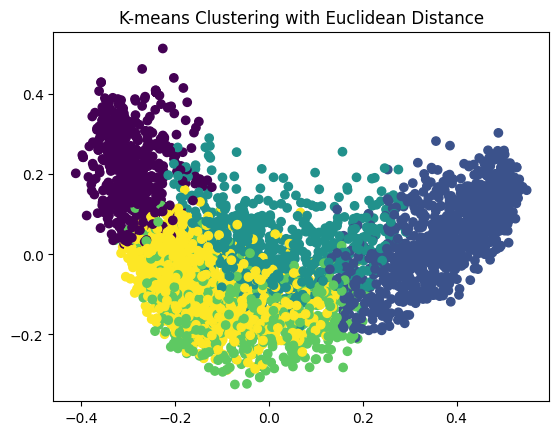

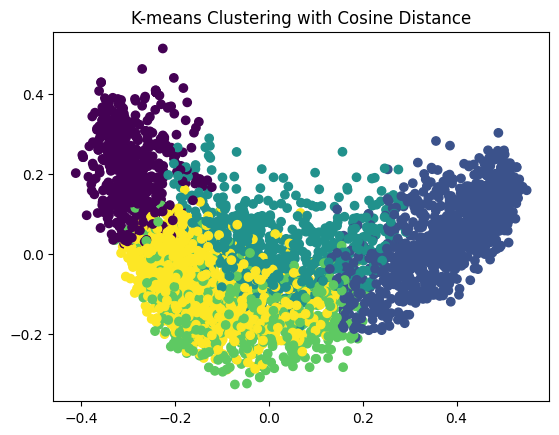

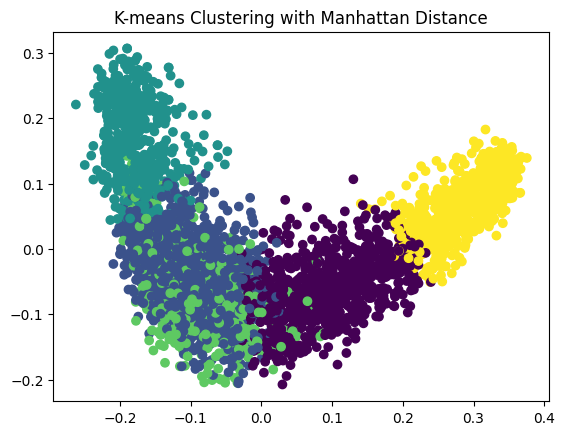

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# кластеры K-means
def visualize_clusters(matrix, labels, title):
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(matrix)
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

visualize_clusters(embeddings, labels_euclidean, 'K-means Clustering with Euclidean Distance')
visualize_clusters(embeddings_normalized, labels_cosine, 'K-means Clustering with Cosine Distance')
visualize_clusters(embeddings_manhattan, labels_manhattan, 'K-means Clustering with Manhattan Distance')

### DBSCAN кластеризация с евклидовым, косинусным и манхэттенским расстоянием

In [14]:
dbscan_euclidean = DBSCAN(metric='euclidean', eps=0.5, min_samples=5)
labels_dbscan_euclidean = dbscan_euclidean.fit_predict(embeddings)
if len(set(labels_dbscan_euclidean)) > 1:
    score_dbscan_euclidean = silhouette_score(embeddings, labels_dbscan_euclidean, metric='euclidean')
    print(f'Silhouette Score for DBSCAN with Euclidean distance: {score_dbscan_euclidean}')
else:
    print("DBSCAN with Euclidean distance did not find multiple clusters.")

dbscan_cosine = DBSCAN(metric='cosine', eps=0.7, min_samples=3)
labels_dbscan_cosine = dbscan_cosine.fit_predict(embeddings_normalized)
if len(set(labels_dbscan_cosine)) > 1:
    score_dbscan_cosine = silhouette_score(embeddings_normalized, labels_dbscan_cosine, metric='cosine')
    print(f'Silhouette Score for DBSCAN with Cosine distance: {score_dbscan_cosine}')
else:
    print("DBSCAN with Cosine distance did not find multiple clusters.")

dbscan_manhattan = DBSCAN(metric='manhattan', eps=0.5, min_samples=5)
labels_dbscan_manhattan = dbscan_manhattan.fit_predict(embeddings)
if len(set(labels_dbscan_manhattan)) > 1:
    score_dbscan_manhattan = silhouette_score(embeddings, labels_dbscan_manhattan, metric='manhattan')
    print(f'Silhouette Score for DBSCAN with Manhattan distance: {score_dbscan_manhattan}')
else:
    print("DBSCAN with Manhattan distance did not find multiple clusters.")

Silhouette Score for DBSCAN with Euclidean distance: -0.10109095275402069
DBSCAN with Cosine distance did not find multiple clusters.
Silhouette Score for DBSCAN with Manhattan distance: 0.03119966550190481


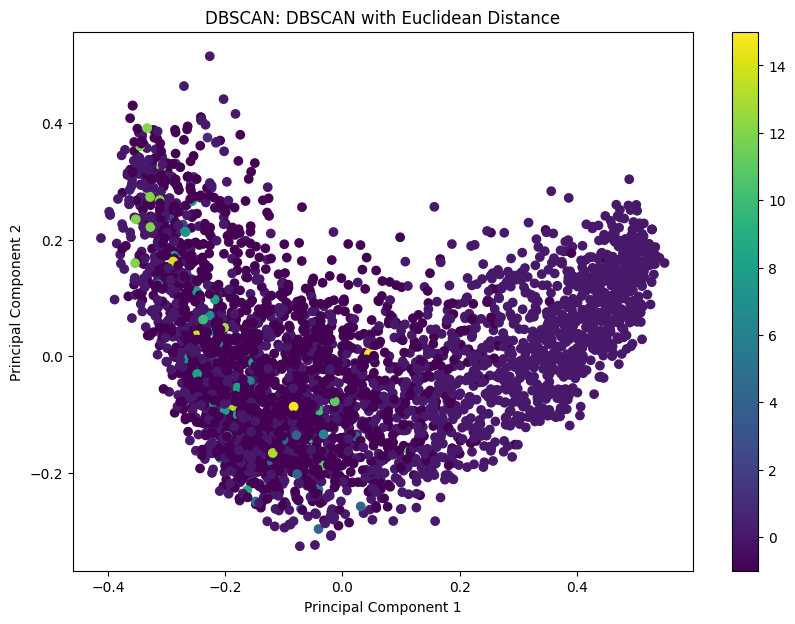

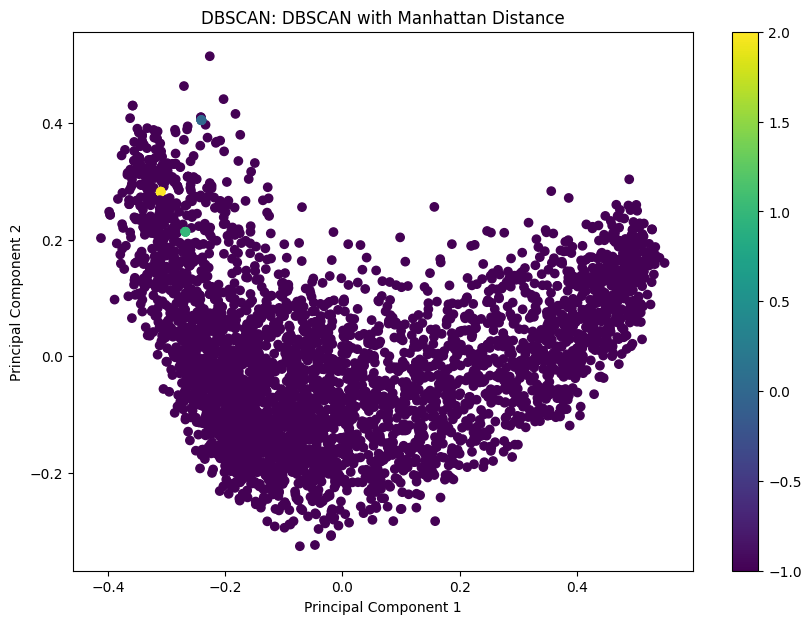

In [15]:
# кластеры DBSCAN
def visualize_dbscan_clusters(matrix, labels, title):
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(matrix)
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels, cmap='viridis')
    plt.title(f'DBSCAN: {title}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

if len(set(labels_dbscan_euclidean)) > 1:
    visualize_dbscan_clusters(embeddings, labels_dbscan_euclidean, 'DBSCAN with Euclidean Distance')

if len(set(labels_dbscan_cosine)) > 1:
    visualize_dbscan_clusters(embeddings_normalized, labels_dbscan_cosine, 'DBSCAN with Cosine Distance')

if len(set(labels_dbscan_manhattan)) > 1:
    visualize_dbscan_clusters(embeddings, labels_dbscan_manhattan, 'DBSCAN with Manhattan Distance')

### BERTopic

In [16]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(processed_paragraphs, embeddings)

topic_info = topic_model.get_topic_info()
print(topic_info)

topic_model.visualize_topics()

   Topic  Count                         Name  \
0     -1      9   -1_se_nicher_vertu_vatelle   
1      0   3589        0_cinq_sous_guerre_du   
2      1     42  1_en_umsonst_toutes_rigueur   
3      2     39                        2____   
4      3     30                        3____   

                                      Representation  \
0         [se, nicher, vertu, vatelle, la, , , , , ]   
1  [cinq, sous, guerre, du, ax, la, mehr, vous, u...   
2  [en, umsonst, toutes, rigueur, lettres, cest, ...   
3                               [, , , , , , , , , ]   
4                               [, , , , , , , , , ]   

                                 Representative_Docs  
0  [такса авдотья романович внушительно проговори...  
1  [ax вскрикнуть соня испуганно, почтенный край ...  
2  [дом преследовать беззащитный девица оскорблят...  
3  [вообразить родя вчера съехать преступление го...  
4  [судопроизводство дело пройти больший затрудне...  


Результаты одинаково плохи везде и такое повторится в файле по предложениям. Думаю, дело в предобработке и разделении текста на фрагменты.